In [1]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "sagemaker/DEMO-pca"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

In [3]:
DATA_DIR = './'

In [4]:
all_data = pd.read_csv(DATA_DIR + 'all_matches_details.csv')

In [5]:
all_data.head()

,innings,delivery_no,delivery_no_over,non_striker,bowler,runs_extras,runs_total,runs_batsman,batsman,player_out,player_out_kind,match_no
0,1st innings,0,0.1,Shubman Gill,TA Boult,0,0,0,RA Tripathi,NaN,NaN,1216526
1,1st innings,1,0.2,Shubman Gill,TA Boult,0,1,1,RA Tripathi,NaN,NaN,1216526
2,1st innings,2,0.3,RA Tripathi,TA Boult,0,0,0,Shubman Gill,NaN,NaN,1216526
3,1st innings,3,0.4,RA Tripathi,TA Boult,1,1,0,Shubman Gill,NaN,NaN,1216526
4,1st innings,4,0.5,RA Tripathi,TA Boult,0,0,0,Shubman Gill,NaN,NaN,1216526


In [6]:
runs_bowler = all_data.groupby(["bowler"])["runs_total"].sum()
runs_bowler = runs_bowler.reset_index()
runs_bowler

,bowler,runs_total
0,A Mishra,72
1,A Nortje,529
2,A Zampa,92
3,AD Russell,178
4,AJ Tye,54
...,...,...
93,UT Yadav,86
94,V Shankar,82
95,VR Aaron,96
96,Washington Sundar,300


In [7]:
deliveries_bowler = all_data.groupby(["bowler"])["bowler"].count()
deliveries_bowler = deliveries_bowler.reset_index(name = "deliveries")
deliveries_bowler

,bowler,deliveries
0,A Mishra,61
1,A Nortje,376
2,A Zampa,67
3,AD Russell,114
4,AJ Tye,27
...,...,...
93,UT Yadav,46
94,V Shankar,84
95,VR Aaron,54
96,Washington Sundar,302


In [8]:
wickets_bowler = all_data[all_data["player_out"].isna() == False]

In [9]:
wickets_bowler = wickets_bowler.groupby(["bowler"])["bowler"].count()
wickets_bowler = wickets_bowler.reset_index(name = "wickets")
wickets_bowler

,bowler,wickets
0,A Mishra,3
1,A Nortje,23
2,A Zampa,2
3,AD Russell,7
4,AJ Tye,2
...,...,...
74,TU Deshpande,3
75,UT Yadav,1
76,V Shankar,4
77,Washington Sundar,9


In [10]:
bowler_stats = runs_bowler.merge(deliveries_bowler, how = "left")

In [11]:
bowler_stats = bowler_stats.merge(wickets_bowler, how="left")

In [12]:
bowler_stats

,bowler,runs_total,deliveries,wickets
0,A Mishra,72,61,3.0
1,A Nortje,529,376,23.0
2,A Zampa,92,67,2.0
3,AD Russell,178,114,7.0
4,AJ Tye,54,27,2.0
...,...,...,...,...
93,UT Yadav,86,46,1.0
94,V Shankar,82,84,4.0
95,VR Aaron,96,54,NaN
96,Washington Sundar,300,302,9.0


In [13]:
bowler_stats = bowler_stats[bowler_stats["deliveries"] > bowler_stats["deliveries"].median()]

In [14]:
bowler_stats["average"] = round(bowler_stats["runs_total"] / bowler_stats["wickets"],2)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_plot(fig_size_x = 15,
              fig_size_y = 10,
              tick_params_labelsize = 14,
             xlabel_name_fontsize = 20,
             ylabel_name_fontsize = 20,
             title_name_fontsize = 20,
             xlabel_name = "",
             ylabel_name = "",
             title_name = ""):
    
    #get current figure 
    fig=plt.gcf()
    
    #set the size of the figure
    fig.set_size_inches(fig_size_x,fig_size_y)

    #get axes of the current figure 
    ax =  fig.gca()

    # set the label size of the ticks of the axes
    ax.tick_params(labelsize=tick_params_labelsize)

    # set the label size of the x axis
    ax.set_xlabel(xlabel_name,fontsize = xlabel_name_fontsize)

    # set the label size of the y axis
    ax.set_ylabel(ylabel_name,fontsize = ylabel_name_fontsize)

     # set the title of the plot
    ax.set_title(title_name,fontsize = title_name_fontsize)

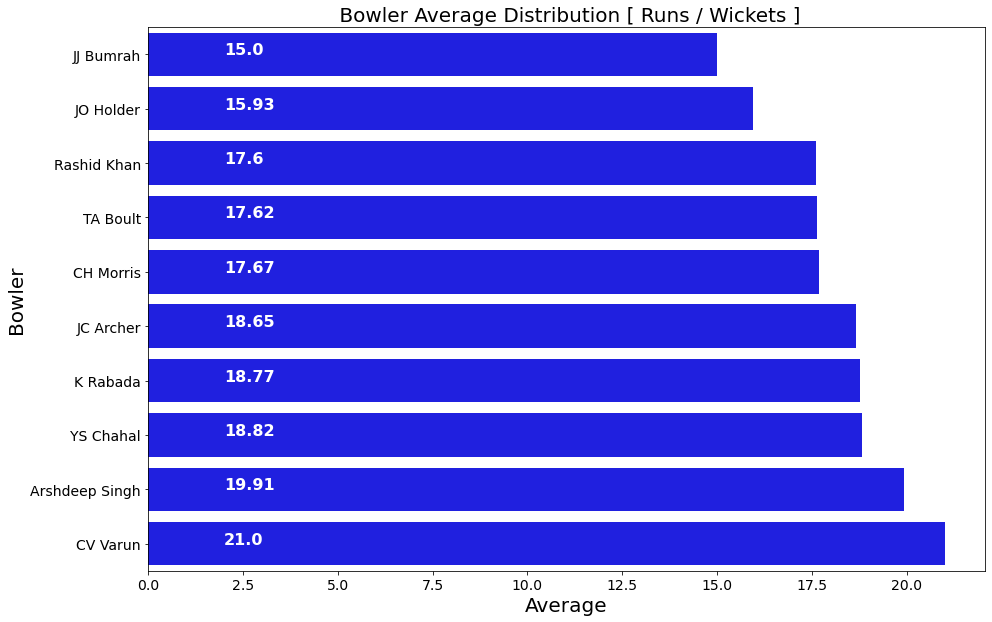

In [16]:
bowler_stats = bowler_stats.sort_values(by = "average",ascending = True)
xlabel_name = "Average"
ylabel_name = "Bowler"
title_name = " Bowler Average Distribution [ Runs / Wickets ]"

sns.barplot( x = "average" , y = "bowler" , data = bowler_stats.head(10), color = "blue")

draw_plot(xlabel_name = xlabel_name ,
             ylabel_name = ylabel_name,
             title_name = title_name)

fig = plt.gcf()
ax = fig.gca()


for i , v in enumerate(bowler_stats.head(10)["average"].values):
    ax.text(2, i, v,fontsize=16,color='white',weight='bold')

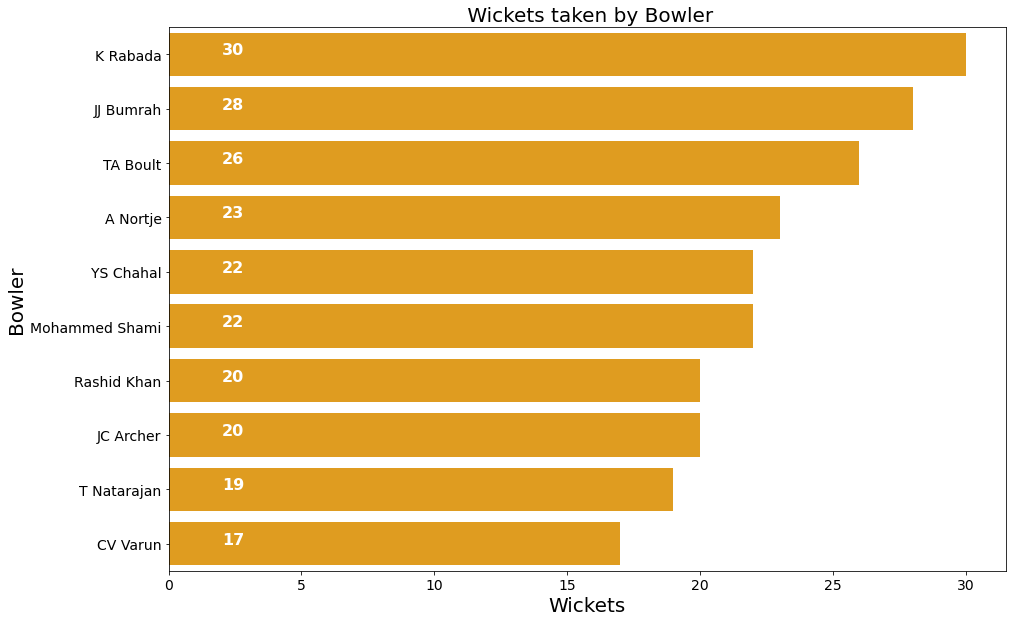

In [17]:
wickets_bowler = wickets_bowler.sort_values(by = "wickets",ascending = False)
xlabel_name = "Wickets"
ylabel_name = "Bowler"
title_name = " Wickets taken by Bowler"

sns.barplot( x = "wickets" , y = "bowler" , data = wickets_bowler.head(10), color = "orange")

draw_plot(xlabel_name = xlabel_name ,
             ylabel_name = ylabel_name,
             title_name = title_name)

fig = plt.gcf()
ax = fig.gca()


for i , v in enumerate(wickets_bowler.head(10)["wickets"].values):
    ax.text(2, i, v,fontsize=16,color='white',weight='bold')

In [18]:
bowler_stats["strike_rate"] = round(bowler_stats["deliveries"] / bowler_stats["wickets"],2)

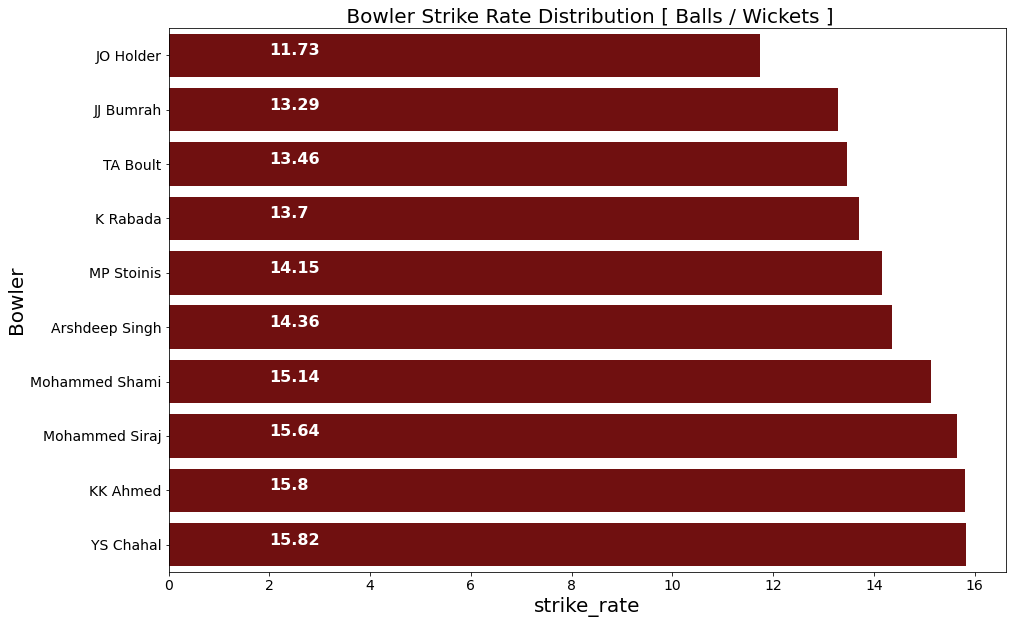

In [19]:
bowler_stats = bowler_stats.sort_values(by = "strike_rate",ascending = True)
xlabel_name = "strike_rate"
ylabel_name = "Bowler"
title_name = " Bowler Strike Rate Distribution [ Balls / Wickets ]"

sns.barplot( x = "strike_rate" , y = "bowler" , data = bowler_stats.head(10), color = "maroon")

draw_plot(xlabel_name = xlabel_name ,
             ylabel_name = ylabel_name,
             title_name = title_name)

fig = plt.gcf()
ax = fig.gca()


for i , v in enumerate(bowler_stats.head(10)["strike_rate"].values):
    ax.text(2, i, v,fontsize=16,color='white',weight='bold')

In [20]:
bowler_stats["econ"] = round((bowler_stats["runs_total"] / bowler_stats["deliveries"])*6,2)

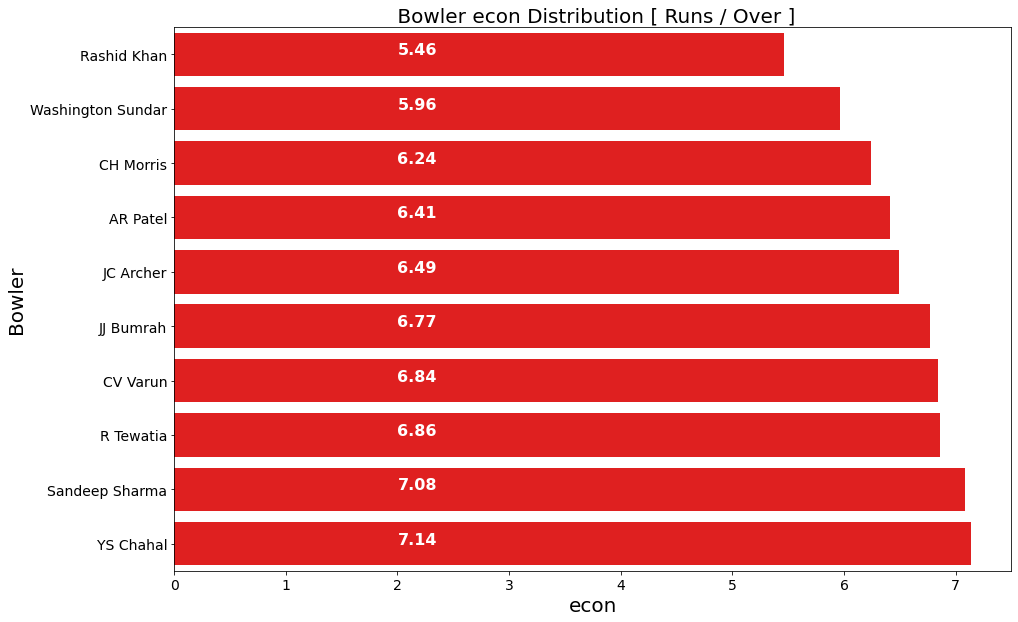

In [21]:
bowler_stats = bowler_stats.sort_values(by = "econ",ascending = True)
xlabel_name = "econ"
ylabel_name = "Bowler"
title_name = " Bowler econ Distribution [ Runs / Over ]"

sns.barplot( x = "econ" , y = "bowler" , data = bowler_stats.head(10), color = "red")

draw_plot(xlabel_name = xlabel_name ,
             ylabel_name = ylabel_name,
             title_name = title_name)

fig = plt.gcf()
ax = fig.gca()


for i , v in enumerate(bowler_stats.head(10)["econ"].values):
    ax.text(2, i, v,fontsize=16,color='white',weight='bold')

In [22]:
bowler_stats["deliveries"].median()

230.0

In [23]:
bowler_stats.sort_values(by="deliveries",ascending = False)

,bowler,runs_total,deliveries,wickets,average,strike_rate,econ
41,K Rabada,563,411,30.0,18.77,13.70,8.22
89,T Natarajan,520,389,19.0,27.37,20.47,8.02
75,Rashid Khan,352,387,20.0,17.60,19.35,5.46
1,A Nortje,529,376,23.0,23.00,16.35,8.44
36,JJ Bumrah,420,372,28.0,15.00,13.29,6.77
90,TA Boult,458,350,26.0,17.62,13.46,7.85
97,YS Chahal,414,348,22.0,18.82,15.82,7.14
33,JC Archer,373,345,20.0,18.65,17.25,6.49
60,Mohammed Shami,474,333,22.0,21.55,15.14,8.54
74,RD Chahar,439,323,16.0,27.44,20.19,8.15


In [24]:
bowler_stats.columns

Index(['bowler', 'runs_total', 'deliveries', 'wickets', 'average',
       'strike_rate', 'econ'],
      dtype='object')

In [25]:
bowler_stats = bowler_stats[bowler_stats["deliveries"] > bowler_stats["deliveries"].median()]

In [26]:
bowler_all_stats_4 = bowler_stats[['wickets', 'average','strike_rate', 'econ']]

bowler_all_stats_4 = bowler_all_stats_4.fillna(0)
bowler_all_stats_4.index =bowler_stats.bowler

from sklearn.preprocessing import scale
X = pd.DataFrame(scale(bowler_all_stats_4), index=bowler_all_stats_4.index, columns=bowler_all_stats_4.columns)

X

,wickets,average,strike_rate,econ
bowler,,,,
Rashid Khan,0.594055,-0.970861,-0.430497,-2.300404
Washington Sundar,-1.110625,0.382608,1.141248,-1.729466
AR Patel,-0.800683,0.088338,0.526266,-1.215622
JC Archer,0.594055,-0.880515,-0.662775,-1.124272
JJ Bumrah,1.833823,-1.194575,-1.100784,-0.804547
CV Varun,0.129142,-0.678312,-0.534469,-0.724615
R Tewatia,-0.800683,0.072850,0.305049,-0.701778
Sandeep Sharma,-0.335770,-0.187002,-0.066595,-0.450565
YS Chahal,0.903997,-0.865887,-0.820945,-0.382053


In [27]:
from sagemaker.image_uris import retrieve

container = retrieve(framework="pca", region=boto3.Session().region_name)

In [28]:
container

'174872318107.dkr.ecr.us-west-2.amazonaws.com/pca:1'

In [29]:
numpy_array = X.to_numpy()

In [30]:
numpy_array

array([[ 0.5940555 , -0.97086077, -0.43049715, -2.30040403],
       [-1.1106255 ,  0.38260806,  1.14124836, -1.72946611],
       [-0.8006835 ,  0.08833829,  0.5262656 , -1.21562198],
       [ 0.5940555 , -0.88051479, -0.66277481, -1.12427192],
       [ 1.83382349, -1.19457463, -1.10078412, -0.80454668],
       [ 0.1291425 , -0.67831189, -0.53446906, -0.72461537],
       [-0.8006835 ,  0.07285041,  0.30504878, -0.70177786],
       [-0.3357705 , -0.18700184, -0.06659548, -0.45056517],
       [ 0.9039975 , -0.86588735, -0.82094484, -0.38205262],
       [-0.3357705 , -0.14397994, -0.05885289, -0.32495883],
       [-1.57553849,  3.06459302,  3.23617166, -0.11942118],
       [-0.6457125 ,  0.3972355 ,  0.38800509,  0.04044144],
       [-0.1807995 , -0.23088417, -0.27011496,  0.09753523],
       [ 1.52388149, -0.9691399 , -1.08198069,  0.42867922],
       [-0.3357705 , -0.34618285, -0.47695268,  0.4629355 ],
       [-0.6457125 ,  0.55469564,  0.38800509,  0.52002929],
       [-1.4205675 ,  2.

In [32]:
import sagemaker.amazon.common as smac
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, numpy_array)
buf.seek(0)

0

In [33]:
key = "recordio-pb-data"
boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)
s3_train_data = f"s3://{bucket}/{prefix}/train/{key}"
print(f"uploaded training data location: {s3_train_data}")

uploaded training data location: s3://sagemaker-us-west-2-113170463366/sagemaker/DEMO-pca/train/recordio-pb-data


In [34]:
s3_train_data

's3://sagemaker-us-west-2-113170463366/sagemaker/DEMO-pca/train/recordio-pb-data'

In [35]:
pca = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)

In [36]:
pca.set_hyperparameters(
    feature_dim=4,
    num_components=3,
    subtract_mean=False,
    algorithm_mode="randomized",
    mini_batch_size=200,
)

In [37]:
pca.fit({"train": s3_train_data})

2022-03-17 13:05:20 Starting - Starting the training job...
2022-03-17 13:05:43 Starting - Launching requested ML instancesProfilerReport-1647522320: InProgress
......
2022-03-17 13:06:50 Starting - Preparing the instances for training.........
2022-03-17 13:08:15 Downloading - Downloading input data...
2022-03-17 13:08:49 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/17/2022 13:08:52 INFO 139621298952000] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[03/17/2022 13:08:52 INFO 139621298952000] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'feature_dim

In [38]:
pca_predictor = pca.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

--------!

In [ ]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

pca_predictor.ContentType = "text/csv"
pca_predictor.serializer = CSVSerializer()
pca_predictor.deserializer = JSONDeserializer()

In [ ]:
result = pca_predictor.predict(numpy_array)
print(result)

In [ ]:
eigenvalues = []
eigenvalues += [r["projection"] for r in result["projections"]]

In [ ]:
eigenvalues

In [ ]:
X2 = pd.DataFrame(eigenvalues, index=bowler_all_stats_4.index, columns=["PC1","PC2","PC3"])

In [ ]:
X2

In [ ]:
X2 = X2.reset_index()

In [ ]:
X2.sort_values(by = 'PC1',ascending = False)

In [ ]:
import sagemaker

sagemaker.Session().delete_endpoint(pca_predictor.endpoint_name)